In [1]:
!pip install sentence_transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# 장치 설정 (GPU가 사용 가능하면 GPU 사용, 그렇지 않으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
print(f"Using device: {device}")

# Sentence-BERT 모델 로드
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

# 데이터 전처리
df_selected = pd.read_csv('/content/sample_data/c2d2_0924_final.csv')

# LabelEncoder를 이용해 레이블을 숫자로 변환
label_encoder = LabelEncoder()
df_selected['label'] = label_encoder.fit_transform(df_selected['label'])

# 'thought' 칼럼은 그대로 사용
# 만약 'thought' 칼럼이 리스트나 기타 형식이라면 문자열로 변환
def process_thought(thought_str):
    try:
        thought_list = ast.literal_eval(thought_str)
        if isinstance(thought_list, list):
            return ' '.join([str(item) for item in thought_list])
        else:
            return str(thought_list)
    except:
        print("애러가 발생해서 빈 문자열로 처리")
        return ''  # 에러가 나면 빈 문자열 반환

# 'thought' 칼럼 변환
df_selected['thought'] = df_selected['Distorted_문장분리'].apply(process_thought)

# NaN 값 제거 (필요한 경우)
df_selected = df_selected.dropna(subset=['story', 'thought', 'label'])


# 'No Distortion' 레이블의 인덱스를 가져오기 (가정: 레이블 'No Distortion'이 존재함)
no_distortion_label = label_encoder.transform(['No Distortion'])[0]

# 'No Distortion'에 해당하는 데이터 필터링
no_distortion_df = df_selected[df_selected['label'] == no_distortion_label]

# 'No Distortion' 데이터의 절반을 샘플링하여 제거할 인덱스 선택
indices_to_remove = no_distortion_df.sample(frac=0.5, random_state=42).index

# 원래 데이터프레임에서 해당 인덱스 제거
df_selected = df_selected.drop(indices_to_remove)

# 새로운 데이터프레임 확인
print(f"Original No Distortion Count: {len(no_distortion_df)}")
print(f"Reduced No Distortion Count: {len(df_selected[df_selected['label'] == no_distortion_label])}")



/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Original No Distortion Count: 2042
Reduced No Distortion Count: 1021


In [3]:
# 레이블 매핑 출력
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:")
for label_name, label_number in label_mapping.items():
    print(f"'{label_name}': {label_number}")


Label mapping:
'All-or-nothing thinking': 0
'Emotional Reasoning': 1
'Fortune-telling': 2
'Labeling': 3
'Mind Reading': 4
'No Distortion': 5
'Overgeneralization': 6
'Personalization': 7
'nan': 8


In [4]:

# Dataset 정의
class StoryDataset(Dataset):
    def __init__(self, dataframe):
        self.story = dataframe['story'].values
        self.thought = dataframe['thought'].values  # thought 텍스트
        self.label = dataframe['label'].values

    def __len__(self):
        return len(self.story)

    def __getitem__(self, idx):
        story_text = self.story[idx]
        thought_text = self.thought[idx]
        label = self.label[idx]

        return story_text, thought_text, torch.tensor(label, dtype=torch.long)

# 모델 정의
class MultiOutputModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels):
        super(MultiOutputModel, self).__init__()
        self.fc = nn.Linear(embedding_dim * 2, hidden_dim)  # story와 thought 임베딩을 결합
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.output = nn.Linear(hidden_dim, num_labels)  # 레이블 예측

    def forward(self, combined_embedding):
        x = self.relu(self.fc(combined_embedding))
        x = self.dropout(x)
        x = self.output(x)
        return x

# 학습, 검증 및 테스트 데이터 분리 (train: 80%, val: 10%, test: 10%)
train_df, temp_df = train_test_split(df_selected, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)



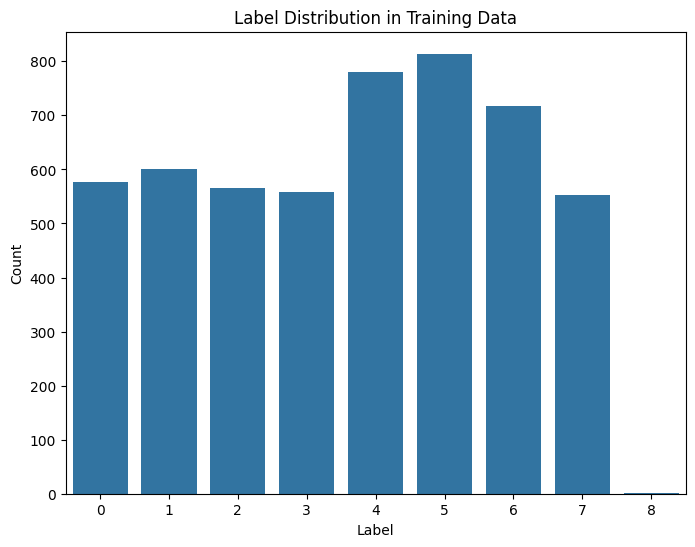

Label Counts:
 label
5    814
4    781
6    717
1    601
0    577
2    566
3    559
7    552
8      1
Name: count, dtype: int64


In [5]:
# 라벨별 데이터 분포 시각화

label_counts = train_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Training Data')
plt.show()

print("Label Counts:\n", label_counts)


In [6]:
train_df = train_df[train_df["label"] != 8]

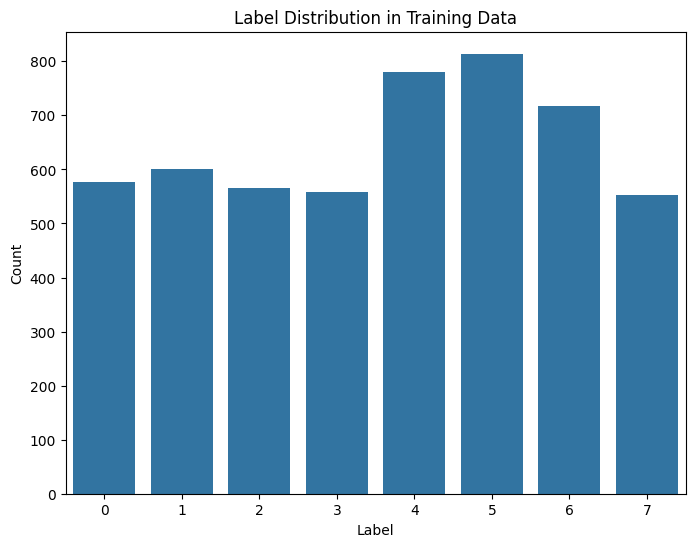

Label Counts:
 label
5    814
4    781
6    717
1    601
0    577
2    566
3    559
7    552
Name: count, dtype: int64


In [7]:
label_counts = train_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Training Data')
plt.show()

print("Label Counts:\n", label_counts)


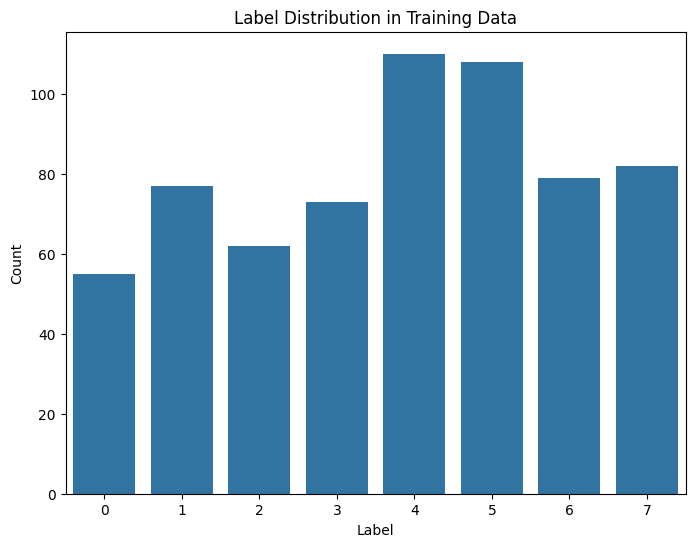

Label Counts:
 label
4    110
5    108
7     82
6     79
1     77
3     73
2     62
0     55
Name: count, dtype: int64


In [8]:
# 라벨별 데이터 분포 시각화
label_counts = val_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Training Data')
plt.show()

print("Label Counts:\n", label_counts)

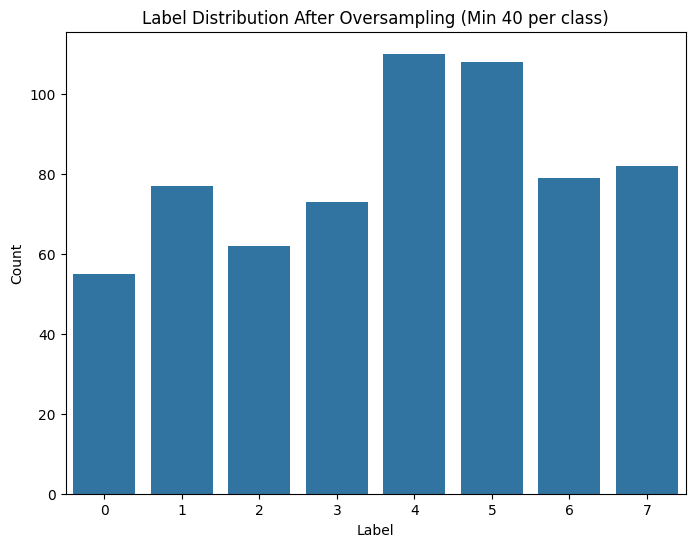

Label Counts After Oversampling:
 label
4    110
5    108
7     82
6     79
1     77
3     73
2     62
0     55
Name: count, dtype: int64


In [9]:
from imblearn.over_sampling import RandomOverSampler

# 데이터프레임을 X와 y로 분리
X = val_df[['story', 'thought']]  # 피처
y = val_df['label']  # 레이블

# 오버샘플링 전략: 각 라벨을 150개로 맞춤
sampling_strategy = {}
for label, count in y.value_counts().items():
    sampling_strategy[label] = max(40, count)  # 각 라벨별 샘플 수를 150개 이상으로 맞춤 (150개 미만인 경우 오버샘플링)

# 오버샘플링 적용
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 오버샘플링된 데이터프레임 생성
val_df = pd.DataFrame(X_resampled, columns=['story', 'thought'])
val_df['label'] = y_resampled

# 오버샘플링 후 라벨별 데이터 분포 시각화
label_counts_resampled = val_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_resampled.index, y=label_counts_resampled.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution After Oversampling (Min 40 per class)')
plt.show()

print("Label Counts After Oversampling:\n", label_counts_resampled)


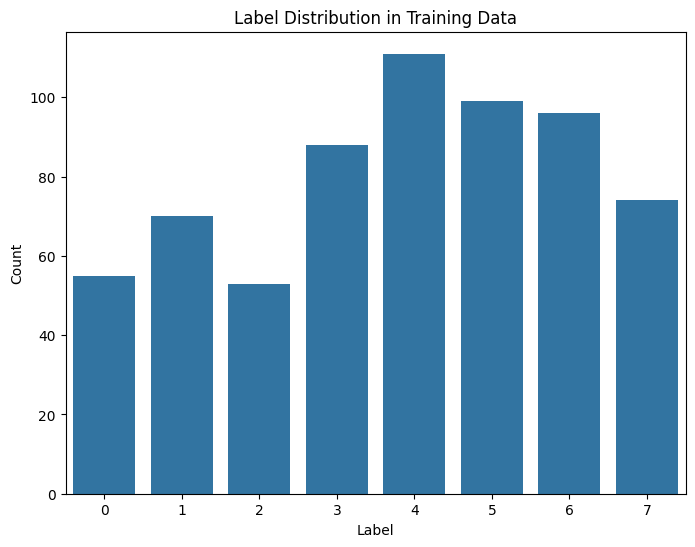

Label Counts:
 label
4    111
5     99
6     96
3     88
7     74
1     70
0     55
2     53
Name: count, dtype: int64


In [10]:
# 라벨별 데이터 분포 시각화
label_counts = test_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Training Data')
plt.show()

print("Label Counts:\n", label_counts)

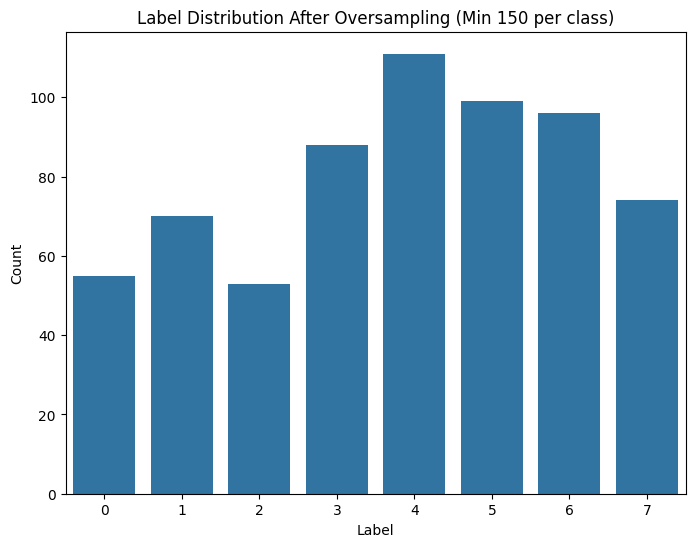

Label Counts After Oversampling:
 label
4    111
5     99
6     96
3     88
7     74
1     70
0     55
2     53
Name: count, dtype: int64


In [11]:
from imblearn.over_sampling import RandomOverSampler

# 데이터프레임을 X와 y로 분리
X = test_df[['story', 'thought']]  # 피처
y = test_df['label']  # 레이블

# 오버샘플링 전략: 각 라벨을 150개로 맞춤
sampling_strategy = {}
for label, count in y.value_counts().items():
    sampling_strategy[label] = max(40, count)  # 각 라벨별 샘플 수를 150개 이상으로 맞춤 (150개 미만인 경우 오버샘플링)

# 오버샘플링 적용
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 오버샘플링된 데이터프레임 생성
test_df = pd.DataFrame(X_resampled, columns=['story', 'thought'])
test_df['label'] = y_resampled

# 오버샘플링 후 라벨별 데이터 분포 시각화
label_counts_resampled = test_df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_resampled.index, y=label_counts_resampled.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution After Oversampling (Min 150 per class)')
plt.show()

print("Label Counts After Oversampling:\n", label_counts_resampled)

Unique labels in df_selected after removing label 8: [1 3 6 4 5 0 7 2]


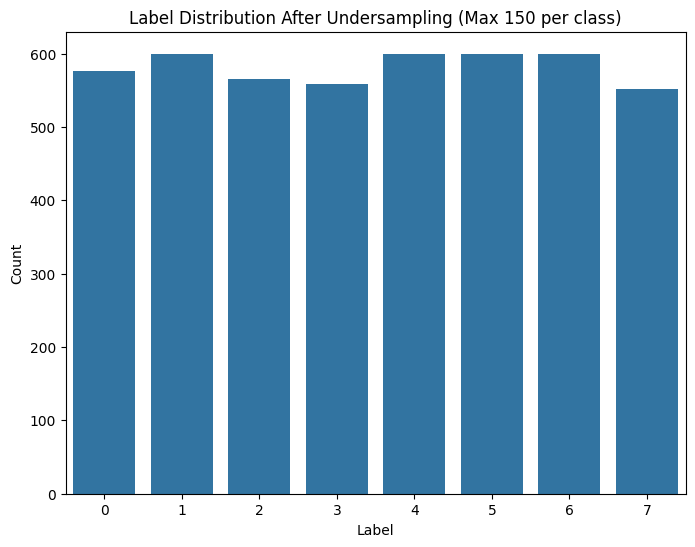

Label Counts After Undersampling:
 label
1    600
6    600
5    600
4    600
0    577
2    566
3    559
7    552
Name: count, dtype: int64


In [12]:
from imblearn.under_sampling import RandomUnderSampler

# 레이블 8번 데이터 제거
train_df = train_df[train_df['label'] != 8]

# 레이블 8번이 제거되었는지 확인
print("Unique labels in df_selected after removing label 8:", train_df['label'].unique())


# 데이터프레임을 X와 y로 분리
X = train_df[['story', 'thought']]  # 피처
y = train_df['label']  # 레이블

# 각 라벨의 데이터 수에 따라 150개로 맞추거나 그 이하인 경우 원래 크기 유지
sampling_strategy = {}
for label, count in y.value_counts().items():
    sampling_strategy[label] = min(600, count)  # 각 라벨별 샘플 수를 150개로 제한 (150개 미만이면 그대로 유지)

# 언더샘플링 적용
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 언더샘플링된 데이터프레임 생성
train_df_resampled = pd.DataFrame(X_resampled, columns=['story', 'thought'])
train_df_resampled['label'] = y_resampled

# 언더샘플링 후 라벨별 데이터 분포 시각화
label_counts_resampled = train_df_resampled['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_resampled.index, y=label_counts_resampled.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution After Undersampling (Max 150 per class)')
plt.show()

print("Label Counts After Undersampling:\n", label_counts_resampled)


In [13]:
"""from imblearn.over_sampling import RandomOverSampler

# 데이터프레임을 X와 y로 분리
X = train_df_resampled[['story', 'thought']]  # 피처
y = train_df_resampled['label']  # 레이블

# 오버샘플링 전략: 각 라벨을 150개로 맞춤
sampling_strategy = {}
for label, count in y.value_counts().items():
    sampling_strategy[label] = max(200, count)  # 각 라벨별 샘플 수를 150개 이상으로 맞춤 (150개 미만인 경우 오버샘플링)

# 오버샘플링 적용
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 오버샘플링된 데이터프레임 생성
train_df_resampled = pd.DataFrame(X_resampled, columns=['story', 'thought'])
train_df_resampled['label'] = y_resampled

# 오버샘플링 후 라벨별 데이터 분포 시각화
label_counts_resampled = train_df_resampled['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_resampled.index, y=label_counts_resampled.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution After Oversampling (Min 150 per class)')
plt.show()

print("Label Counts After Oversampling:\n", label_counts_resampled)
"""

'from imblearn.over_sampling import RandomOverSampler\n\n# 데이터프레임을 X와 y로 분리\nX = train_df_resampled[[\'story\', \'thought\']]  # 피처\ny = train_df_resampled[\'label\']  # 레이블\n\n# 오버샘플링 전략: 각 라벨을 150개로 맞춤\nsampling_strategy = {}\nfor label, count in y.value_counts().items():\n    sampling_strategy[label] = max(200, count)  # 각 라벨별 샘플 수를 150개 이상으로 맞춤 (150개 미만인 경우 오버샘플링)\n\n# 오버샘플링 적용\nros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)\nX_resampled, y_resampled = ros.fit_resample(X, y)\n\n# 오버샘플링된 데이터프레임 생성\ntrain_df_resampled = pd.DataFrame(X_resampled, columns=[\'story\', \'thought\'])\ntrain_df_resampled[\'label\'] = y_resampled\n\n# 오버샘플링 후 라벨별 데이터 분포 시각화\nlabel_counts_resampled = train_df_resampled[\'label\'].value_counts()\n\nplt.figure(figsize=(8, 6))\nsns.barplot(x=label_counts_resampled.index, y=label_counts_resampled.values)\nplt.xlabel(\'Label\')\nplt.ylabel(\'Count\')\nplt.title(\'Label Distribution After Oversampling (Min 150 per class)\')\nplt.show

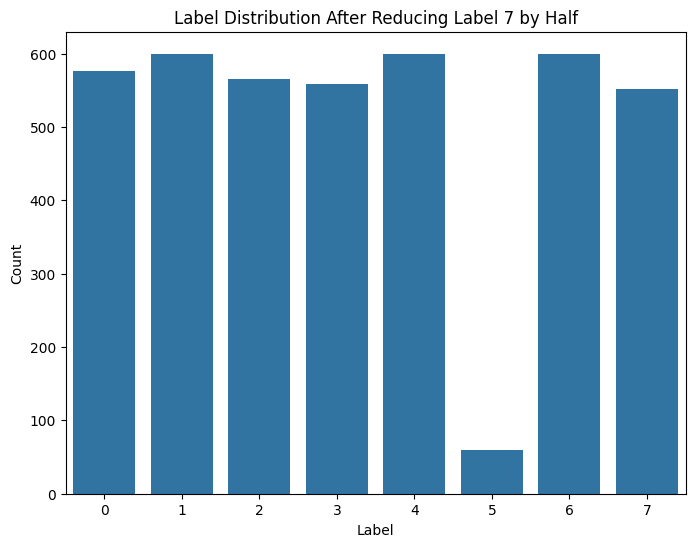

Label Counts After Reducing Label 7 by Half:
 label
1    600
4    600
6    600
0    577
2    566
3    559
7    552
5     60
Name: count, dtype: int64


In [14]:
# 7번 레이블에 해당하는 데이터 필터링
label_7_df = train_df_resampled[train_df_resampled['label'] == 5]

# 7번 레이블 데이터 중 절반을 샘플링하여 제거할 인덱스 선택
indices_to_remove = label_7_df.sample(frac=0.9, random_state=42).index

# 원래 데이터프레임에서 해당 인덱스 제거
train_df_resampled = train_df_resampled.drop(indices_to_remove)

# 새로운 데이터프레임 확인
label_counts_reduced = train_df_resampled['label'].value_counts()

# 라벨별 데이터 분포 시각화 (7번 레이블을 줄인 후)
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_reduced.index, y=label_counts_reduced.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution After Reducing Label 7 by Half')
plt.show()

print("Label Counts After Reducing Label 7 by Half:\n", label_counts_reduced)


In [15]:
# 학습, 검증, 테스트용 데이터셋 준비
train_dataset = StoryDataset(train_df_resampled)
val_dataset = StoryDataset(val_df)
test_dataset = StoryDataset(test_df)

batch_size = 16  # 배치 크기를 늘려서 학습 속도 향상
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 모델, 손실 함수, 옵티마이저 정의
embedding_dim = 384  # sentence-transformers/all-MiniLM-L6-v2 의 임베딩 차원
hidden_dim = 256  # hidden_dim 증가
num_labels = len(df_selected['label'].unique())  # 레이블의 고유한 클래스 수

model = MultiOutputModel(embedding_dim, hidden_dim, num_labels).to(device)  # 모델을 장치로 이동
criterion_label = nn.CrossEntropyLoss()  # 레이블 예측은 분류로 처리
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 학습률 감소


Epoch [1/100], Train Loss: 550.6631, Train Accuracy: 0.1964
Validation Loss: 87.4770, Validation Accuracy: 0.2570
Epoch [2/100], Train Loss: 510.1078, Train Accuracy: 0.3085
Validation Loss: 87.0588, Validation Accuracy: 0.3282
Epoch [3/100], Train Loss: 485.1411, Train Accuracy: 0.3350
Validation Loss: 86.2700, Validation Accuracy: 0.3483
Epoch [4/100], Train Loss: 465.9132, Train Accuracy: 0.3617
Validation Loss: 85.1967, Validation Accuracy: 0.3545
Epoch [5/100], Train Loss: 449.9483, Train Accuracy: 0.3991
Validation Loss: 84.4859, Validation Accuracy: 0.3483
Epoch [6/100], Train Loss: 436.6505, Train Accuracy: 0.4098
Validation Loss: 82.2945, Validation Accuracy: 0.3545
Epoch [7/100], Train Loss: 424.7393, Train Accuracy: 0.4305
Validation Loss: 81.7929, Validation Accuracy: 0.3669
Epoch [8/100], Train Loss: 414.2399, Train Accuracy: 0.4407
Validation Loss: 81.0412, Validation Accuracy: 0.3684
Epoch [9/100], Train Loss: 404.8357, Train Accuracy: 0.4558
Validation Loss: 79.2190, Va

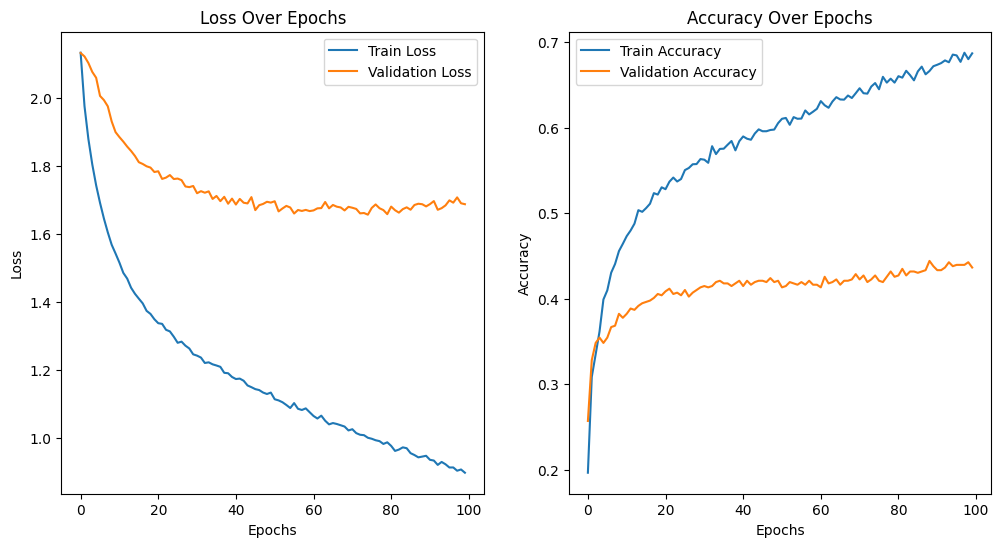

Classification Report:


ValueError: Number of classes, 8, does not match size of target_names, 9. Try specifying the labels parameter

In [16]:

# 학습 함수 정의
def train_model(model, train_loader, val_loader, epochs=10):
    # 학습 기록 저장을 위한 리스트
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0  # 가장 좋은 검증 정확도
    best_model_state = None  # 가장 좋은 모델 상태 저장

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train_label = 0
        total_train_label = 0

        # 학습 단계
        for story_texts, thought_texts, labels in train_loader:
            optimizer.zero_grad()

            # 스토리와 생각 임베딩 (배치 단위)
            story_embeddings = sbert_model.encode(story_texts, convert_to_tensor=True, device=device)
            thought_embeddings = sbert_model.encode(thought_texts, convert_to_tensor=True, device=device)

            # 임베딩 결합
            combined_embeddings = torch.cat((story_embeddings, thought_embeddings), dim=1)

            labels = labels.to(device)

            # 모델 예측
            outputs = model(combined_embeddings)

            # 손실 계산
            loss = criterion_label(outputs, labels)

            # 역전파
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # 정확도 계산 (학습 데이터)
            _, predicted_labels = torch.max(outputs, 1)
            correct_train_label += (predicted_labels == labels).sum().item()
            total_train_label += labels.size(0)

        # 학습 손실과 정확도 저장
        train_losses.append(total_train_loss / len(train_loader))
        train_accuracy = correct_train_label / total_train_label
        train_accuracies.append(train_accuracy)

        # 검증 단계
        model.eval()
        total_val_loss = 0
        correct_val_label = 0
        total_val_label = 0

        all_labels = []
        all_preds = []
        all_story_texts = []
        all_thought_texts = []

        with torch.no_grad():
            for story_texts, thought_texts, labels in val_loader:
                # 스토리와 생각 임베딩 (배치 단위)
                story_embeddings = sbert_model.encode(story_texts, convert_to_tensor=True, device=device)
                thought_embeddings = sbert_model.encode(thought_texts, convert_to_tensor=True, device=device)

                # 임베딩 결합
                combined_embeddings = torch.cat((story_embeddings, thought_embeddings), dim=1)

                labels = labels.to(device)

                # 모델 예측
                outputs = model(combined_embeddings)

                # 손실 계산
                val_loss = criterion_label(outputs, labels)

                total_val_loss += val_loss.item()

                # 정확도 계산 (검증 데이터)
                _, predicted_val_labels = torch.max(outputs, 1)
                correct_val_label += (predicted_val_labels == labels).sum().item()
                total_val_label += labels.size(0)

                # 결과 저장
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted_val_labels.cpu().numpy())
                all_story_texts.extend(story_texts)
                all_thought_texts.extend(thought_texts)

        # 검증 손실과 정확도 저장
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracy = correct_val_label / total_val_label
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # 가장 좋은 모델 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()

    # 가장 좋은 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 학습 손실, 정확도 시각화
    plt.figure(figsize=(12, 6))

    # 학습 및 검증 손실
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # 학습 및 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.show()

    # 분류 리포트 출력
    target_names = label_encoder.classes_
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # 혼동 행렬 출력
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # 예측 결과를 데이터프레임으로 저장
    results_df = pd.DataFrame({
        'Story': all_story_texts,
        'Thought': all_thought_texts,
        'True Label': [target_names[label] for label in all_labels],
        'Predicted Label': [target_names[pred] for pred in all_preds]
    })

    # 일부 예시 출력
    print("Sample Predictions:")
    display(results_df.head(10))

    return results_df  # 결과 데이터프레임 반환

# 학습 및 평가 호출
results_df = train_model(model, train_loader, val_loader, epochs=100)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# 평가 함수 정의
def evaluate_model(model, test_loader):
    model.eval()
    y_true_label = []
    y_pred_label = []

    with torch.no_grad():
        for story_texts, thought_texts, labels in test_loader:
            # 스토리와 생각 임베딩 (배치 단위)
            story_embeddings = sbert_model.encode(story_texts, convert_to_tensor=True, device=device)
            thought_embeddings = sbert_model.encode(thought_texts, convert_to_tensor=True, device=device)

            # 임베딩 결합
            combined_embeddings = torch.cat((story_embeddings, thought_embeddings), dim=1)

            labels = labels.to(device)

            # 모델 예측
            outputs = model(combined_embeddings)

            # 예측값 저장
            y_true_label.extend(labels.cpu().numpy())
            y_pred_label.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    # 다양한 스코어 계산
    accuracy = accuracy_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label, average='weighted')
    precision = precision_score(y_true_label, y_pred_label, average='weighted')
    recall = recall_score(y_true_label, y_pred_label, average='weighted')

    # 레이블별 정확도 계산
    cm = confusion_matrix(y_true_label, y_pred_label)
    label_accuracies = cm.diagonal() / cm.sum(axis=1)  # 각 클래스의 맞춘 샘플 수 / 해당 클래스 전체 샘플 수

    # 출력
    print(f"Overall Label Prediction Accuracy: {accuracy:.4f}")
    print(f"Overall Label Prediction F1 Score: {f1:.4f}")
    print(f"Overall Label Prediction Precision: {precision:.4f}")
    print(f"Overall Label Prediction Recall: {recall:.4f}")

    # 각 레이블별 정확도 출력
    target_names = label_encoder.classes_
    for i, label_accuracy in enumerate(label_accuracies):
        print(f"Accuracy for label '{target_names[i]}': {label_accuracy:.4f}")

# 테스트 데이터에 대한 평가
evaluate_model(model, test_loader)
